reference:  
李宏毅  
https://www.youtube.com/watch?v=oTGFK-QOWI4
https://docs.google.com/presentation/d/1x8c38zgEbN2zN4EboWhquZ5b3LhVCN8ElhaJCO2vnzY/edit?pli=1#slide=id.g228497b0ecc_0_0  
https://www.kaggle.com/code/b07202024/hw6-diffusion-model
hugging face  
https://huggingface.co/learn/diffusion-course/unit1/3  
https://huggingface.co/docs/diffusers/tutorials/basic_training  
https://www.hyperstack.cloud/technical-resources/tutorials/how-to-train-a-stable-diffusion-model  
https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e
Youtube  
https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=1244s  
https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing  

In [1]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


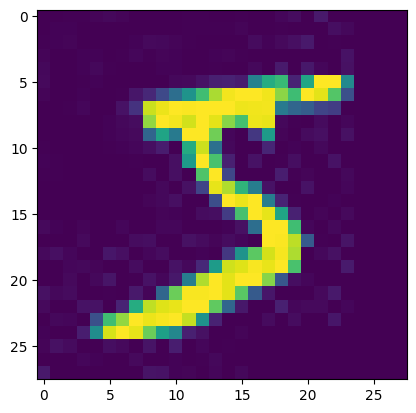

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread('/kaggle/input/minst-dataset/train_img/train_000000.jpg')          
plt.imshow(image)                                   
plt.show()    